# Leverage reflectance data cube to detect field practices

This notebook illustrate how to highlight a tillage event using a reflectance datacube.

In [1]:
import sys
import os
sys.path.append(os.path.join('..','src'))
from geosyspy.utils.constants import *
from dotenv import load_dotenv
from datetime import datetime
import datetime as dt
import logging
from cloud_storage import cloud_storage_aws,cloud_storage_azure
load_dotenv()
import geopandas as gpd
import stackfox
import shapely
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import json
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import zarr
from azure.storage.blob import ContainerClient

# 1️⃣ Plot NDTI images around tillage dates

Winter wheat on this field with harvest at the beginning of June 2021 then tillage a few days after.

In [2]:
account_storage = os.getenv('AZURE_ACCOUNT_NAME')
account_url = f'https://{account_storage}.blob.core.windows.net'
container_name = os.getenv('AZURE_BLOB_CONTAINER_NAME')
prefix = '2021-03-01_2021-07-31_tillage_field_sentinel-2-l2a_datacube.zarr'
credential = os.getenv('AZURE_SAS_CREDENTIAL')

container_client = ContainerClient(account_url=account_url, container_name=container_name, credential=credential)
store = zarr.ABSStore(client=container_client, prefix=prefix)
cube = xr.open_zarr(store=store, consolidated=True)

In [3]:
def NDTI(swir16,swir22):
    return((swir16 - swir22)/(swir16 + swir22))

In [4]:
cube_date_int = cube.sel(time=['2021-04-05T00:00:00.000000000','2021-04-10T00:00:00.000000000', 
                               '2021-04-20T00:00:00.000000000','2021-04-25T00:00:00.000000000', 
                               '2021-04-30T00:00:00.000000000','2021-05-07T00:00:00.000000000',
                               '2021-05-27T00:00:00.000000000', '2021-06-06T00:00:00.000000000',
                               '2021-06-11T00:00:00.000000000', '2021-06-14T00:00:00.000000000',
                               '2021-06-16T00:00:00.000000000', '2021-06-21T00:00:00.000000000'])

In [5]:
dates=[]
NDTIs=[]
for date,cube_date in cube_date_int.groupby('time'):
    NDTIs.append(NDTI(cube_date.swir16,cube_date.swir22))
    dates.append(date)
print(len(NDTIs))

12


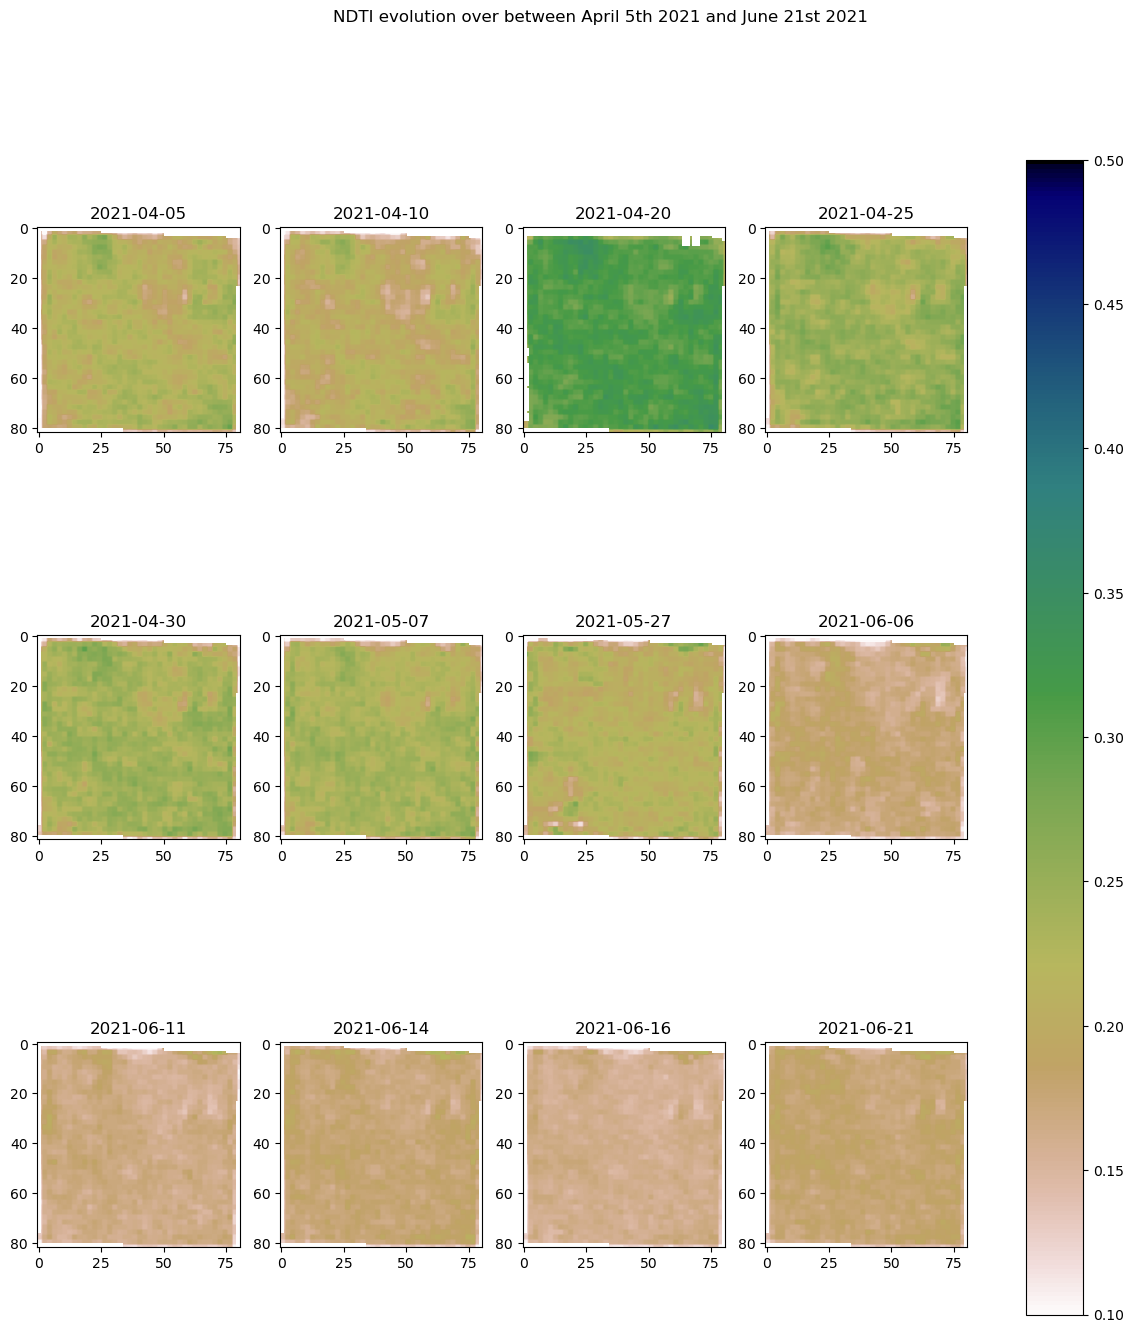

In [6]:
import matplotlib as mpl
cmap = mpl.colormaps['gist_earth']
cmap_reversed = mpl.colormaps.get_cmap('gist_earth_r')

fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(15, 15))
fig.suptitle('NDTI evolution over between April 5th 2021 and June 21st 2021')
i=0
for ax in axes.flat:
    ax.set_title(str(dates[i])[0:10])
    im = ax.imshow(NDTIs[i],vmin=0.10,vmax=0.5,cmap=cmap_reversed)
    i+=1
    
cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
plt.colorbar(im, cax=cax, fraction=0.046, pad=0.04)

plt.show()

 ## 2️⃣ Vegetation index time series

In [7]:
def NDVI(red,nir):
    return(np.nanmedian((nir - red)/(nir + red)))

In [8]:
dates=[]
NDVI_all_dates=[]
for date,cube_date in cube.groupby('time'):
    NDVI_all_dates.append(NDVI(cube_date.red,cube_date.nir08))
    dates.append(date)
print(len(NDVI_all_dates))

31


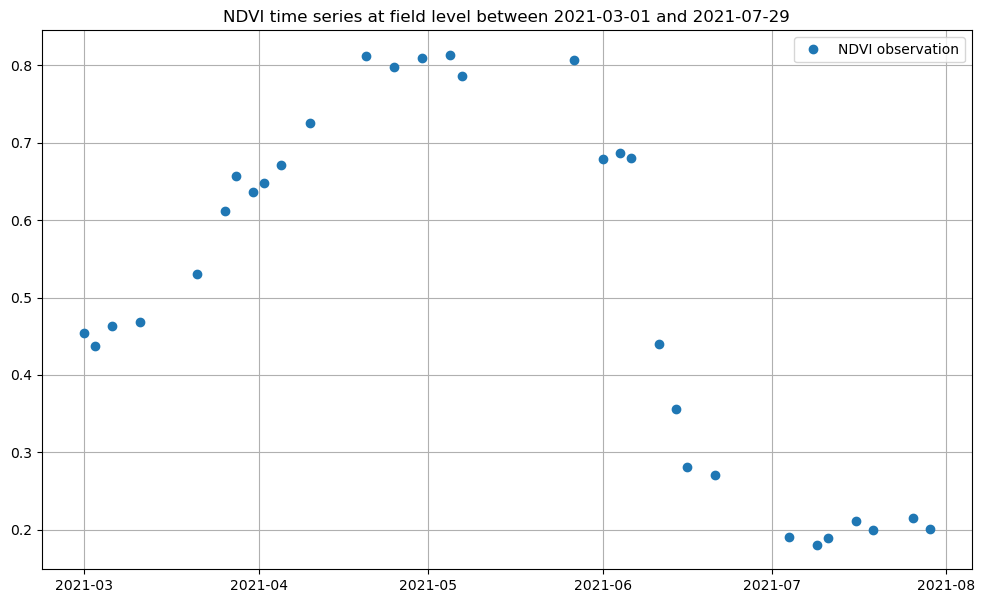

In [9]:
plt.figure(figsize=(12,7))
plt.title(f'NDVI time series at field level between {str(dates[0])[:10]} and {str(dates[-1])[:10]}')
plt.plot_date(dates,NDVI_all_dates,label='NDVI observation')
plt.legend()
plt.grid()


This plot is consistent with harvest then tillage at the beginning of June.